# Simulation in Local Statevector

In [1]:
# Importing Necessary Modules

import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, IBMQ, QuantumCircuit
from qiskit.utils import QuantumInstance
import qiskit.providers as providers
#from qiskit import provider
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Import Qiskit libraries for VQE
from qiskit.algorithms import MinimumEigensolverResult, VQE
from qiskit.algorithms.optimizers import SLSQP, SPSA,COBYLA, L_BFGS_B
# Import Qiskit Nature libraries
from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit_nature.circuit.library.ansatzes import UCC, UCCSD,SUCCD
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper,BravyiKitaevSuperFastMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer,FreezeCoreTransformer
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler, Estimator

from qiskit import IBMQ
provider = IBMQ.load_account()


In [2]:
# Module for Constructing  problem --> Returns energy and dipole moment

def construct_problem(
    geometry, charge:int = 0, multiplicity:int = 1, basis:str = "sto3g",
    trafo:int = 1, remove_orbitals:list = None, num_electrons : int = None, num_molecular_orbitals: int = None,
    active_orbitals : list = None, mapper_type : str = 'PM'
    ):

    '''Defining Molecule object'''
    molecule = Molecule(geometry=geometry,
                            charge=charge, 
                            multiplicity=multiplicity) 
    
    '''Setting up driver - classical computational chemistry program to do preliminary calculations'''

    driver = ElectronicStructureMoleculeDriver(molecule, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF) 

    '''Run the preliminary quantum chemistry calculation'''

    # properties = driver.run() #'properties' object contains properties of molecule calculated through Hartree Fock Method

    '''Set the active space'''

    if trafo == 0: # selecting active space through Active Space Transform
        transformer = ActiveSpaceTransformer(num_electrons=num_electrons, num_molecular_orbitals=num_molecular_orbitals,active_orbitals=active_orbitals)

    if trafo == 1:  # selecting active space through FreezeCore Transform
        transformer = FreezeCoreTransformer(freeze_core=True,remove_orbitals=remove_orbitals)

    '''Applying transformation to get reduced Electronic Structure Problem'''

    problem_reduced = ElectronicStructureProblem(driver, transformers=[transformer]) 


    '''The second quantized Hamiltonian of the reduce problem'''
    #second_q_ops_reduced = problem_reduced.second_q_ops()

    '''Selecting Mapper'''
    if mapper_type == 'PM':
        mapper = ParityMapper()
    elif mapper_type == 'JWM':
        mapper = JordanWignerMapper()
    elif mapper_type == 'BKM':
        mapper = BravyiKitaevMapper()
    elif mapper_type == 'SF-BKM':
        mapper = BravyiKitaevSuperFastMapper()

    """Set the qubit converter with two qubit reduction to reduce the computational cost""" 
    
    converter =  QubitConverter(mapper,two_qubit_reduction=True)  
    
    '''Compute the Hamitonian in qubit form'''
    #qubit_op = converter.convert(second_q_ops_reduced.get('ElectronicEnergy'), num_particles=problem_reduced.num_particles)

    '''Compute the auxillary dipole moment operator in qubit form'''

    # aux_op1 = converter.convert(second_q_ops_reduced.get('DipoleMomentX'), num_particles=problem_reduced.num_particles)
    # aux_op2 = converter.convert(second_q_ops_reduced.get('DipoleMomentY'), num_particles=problem_reduced.num_particles)
    # aux_op3 = converter.convert(second_q_ops_reduced.get('DipoleMomentZ'), num_particles=problem_reduced.num_particles)
    # aux_op = np.array([aux_op1,aux_op2,aux_op3])

    '''Performing VQE using VQEUCC Factory'''

    vqe_factory = VQEUCCFactory(quantum_instance = Aer.get_backend('aer_simulator_statevector'),optimizer= L_BFGS_B(maxiter=100),ansatz= UCC(excitations='sd')) # This is an example of UCC"SD" ansatz
    solver = GroundStateEigensolver(converter, vqe_factory)    
    result = solver.solve(problem_reduced)  

    '''Dipole Moment and Energy Calculation'''  
    dip_tot = result.total_dipole_moment_in_debye[0]
    min_energy = result.total_energies[0]
    

    return dip_tot,min_energy

In [3]:
Dipole = []
Energy =[]
dist = np.linspace(0.5,4,25) # bond lengths
Charge = 0
Multiplicity = 1

Geometry =[[["Li",[0.0000,    0.0000,    0.0000 ]],
        ["H",[d,   0.0000,  0.0000]]] for d in dist]

for geometry in Geometry:
    dipole,energy = construct_problem(geometry=geometry,charge=Charge,multiplicity=Multiplicity,remove_orbitals=[3,4])

    Energy.append(energy)
    Dipole.append(dipole)

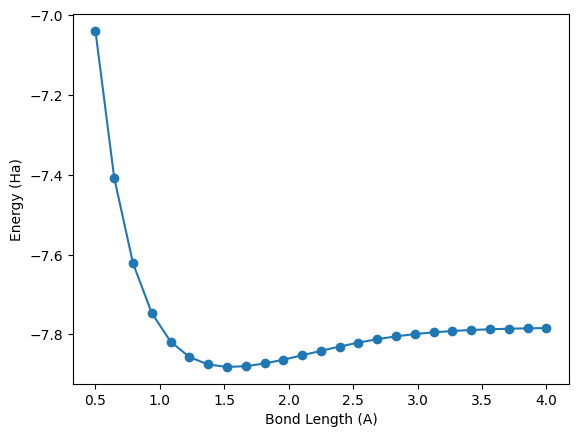

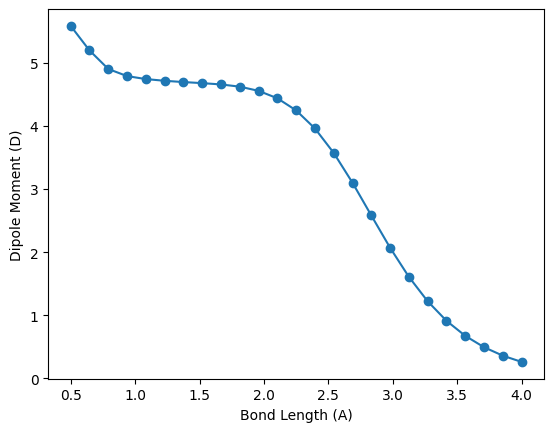

In [4]:
# Plotting 

plt.plot(dist, Energy, '-o')
plt.xlabel('Bond Length (A)')
plt.ylabel('Energy (Ha)')
plt.show()
plt.plot(dist, Dipole, '-o')
plt.xlabel('Bond Length (A)')
plt.ylabel('Dipole Moment (D)')
plt.show()

Here we have used `FreezeCoreTransformer` to select the active space and the mapper used is the `ParityMapper`so that we could make use of two_qubit_reduction. Execuction is done on Statevector Simulator as it performs better than the QASM simulator. To perform VQE using QASM simulator we need to pass the info to the VQEUCC Factory as a quantum instance. The code is shown below: 

# Simulation over cloud devices

Simplest way is set the set the cloud backends as the quantum instance in the VQEUCCFactory, but it will take a lot of time. The circuit we sent over the cloud will be executed as a `circut-runner` which essentially means that, number of jobs we sent for getting one result will be around the maxiter value we provide. In cloud simulator this is not a problem, but in real_backend it will take a awful amount of time. Same problem occurs for the original `VQE` module in the qiskit.algorithms. The VQEEUCCFactory inherits the original VQE classs. The main difference is that, in VQEUCCFactory we can only provide the UCC ansatz whereas the original `VQE` Module can take other ansatzes also. 

NOTE:

The execution of VQE by passing Quantum Instance is now being depricated. Currently qiskit provides the option to pass the Estimator as an argument to both VQEUCCFactory and VQE module. 

Even statevector simulator can be passed into the Estimator.


# Execution by Leveraging Runtime option


### First Approach : VQEClient

VQEClient is one of the option to perform VQE using Runtime. But for VQE client we need to import all the modules from `qiskit_nature.second_q` otherwise it will throw error.

In the paper real backend execution is done using RY ansatz not UCCSD anastz. Here the simulation we use TwoLocal anasatz to create the RY ansatz. Even though VQEclient defined to be a general function currently it is found to be not working for UCCSD ansatz and Statevector Simulator.

In [18]:
import math
import matplotlib.pyplot as plt
import numpy as np

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.mappers import QubitConverter
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer,FreezeCoreTransformer

from qiskit.circuit.library import TwoLocal
from qiskit_nature.second_q.circuit.library.ansatzes import UCC,UCCSD
from qiskit_nature.second_q.circuit.library.initial_states import HartreeFock

from qiskit import Aer, IBMQ, QuantumCircuit
from qiskit.algorithms.optimizers import SPSA, L_BFGS_B
from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_nature.runtime import VQEClient

In [19]:
def construct_problem(bond_distance:float):

    # setting up the driver by specifying atom,charge and spin
    driver = PySCFDriver(
        atom=f"Li 0 0 0; H 0 0 {bond_distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
        )
    # Electronic Structure problem is constructed by runing the driver
    problem = driver.run()

    # specify active space transformation
    transformer = FreezeCoreTransformer(remove_orbitals=[3,4])
    problem_reduced = transformer.transform(problem)

    # construct qubit converter (parity mapping + 2-qubit reduction)
    qubit_converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)

    return qubit_converter,problem_reduced

In [20]:
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')  # replace by your runtime provider
backend = provider.get_backend('ibmq_qasm_simulator')

ibmqfactory.load_account:WARNING:2023-03-02 11:35:58,136: Credentials are already in use. The existing account in the session will be replaced.


In [21]:
num_qubits = 4
init_state = QuantumCircuit(4) #creating initial state according to the paper
init_state.x([0,1])
ansatz = TwoLocal(num_qubits, "ry", "cx",insert_barriers=True,entanglement = 'linear',initial_state=init_state)
optimizer = SPSA(maxiter=200)
initial_point = np.random.random(ansatz.num_parameters)

Initial state can be also created from Hartree Fock Module in the qiskit but the state we get is not matching with the initial state provided in the paper.

In [22]:
runtime_vqe = VQEClient(
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    provider=provider,
    backend=backend,
    shots=20000,#measurement_error_mitigation=True,for i in range(len(Elec_dipole_Moment)):

#If measurement_error_mitigation = True  it is found to be failing the circui

In [23]:
bond_length = np.linspace(1,5,7)
Energy = []
Dipole_moment = []
for dist in bond_length:
    qubit_converter, problem = construct_problem(dist)
    runtime_vqe_groundstate_solver = GroundStateEigensolver(qubit_converter, runtime_vqe)
    runtime_vqe_result = runtime_vqe_groundstate_solver.solve(problem)
    energy = runtime_vqe_result.total_energies[0]
    dipole = runtime_vqe_result.total_dipole_moment_in_debye[0]

    Energy.append(energy)
    Dipole_moment.append(dipole)

Text(0, 0.5, 'E (Ha)')

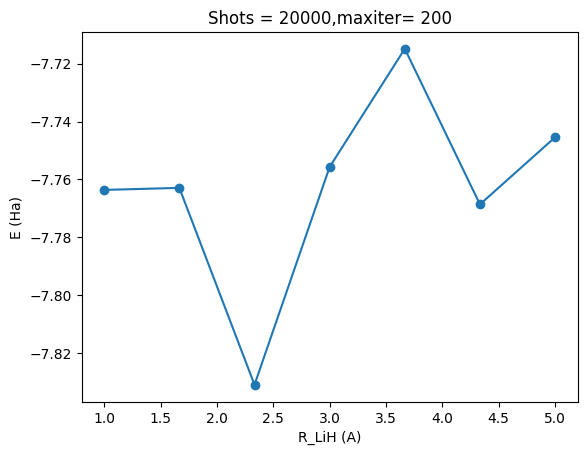

In [24]:
maxiter=optimizer.settings['maxiter']
plt.plot(bond_length,Energy, '-o')
plt.title(f'Shots = {runtime_vqe.shots},maxiter= {maxiter}')
plt.xlabel('R_LiH (A)')
plt.ylabel('E (Ha)')

Text(0, 0.5, 'D ')

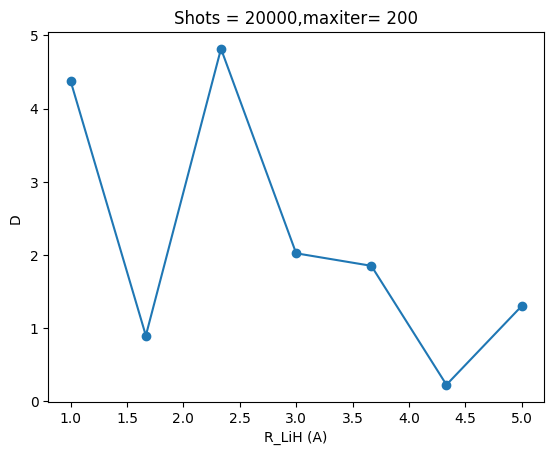

In [25]:
plt.plot(bond_length,Dipole_moment, '-o')
plt.title(f'Shots = {runtime_vqe.shots},maxiter= {maxiter}')
plt.xlabel('R_LiH (A)')
plt.ylabel('D ')

### Second Apporach : VQE Prototype Program

In [10]:
#Runtime
from qiskit_ibm_runtime import Estimator,QiskitRuntimeService

from qiskit import IBMQ
provider = IBMQ.load_account()
provider = IBMQ.get_provider(group='open')

In [3]:
optimizer = SPSA(maxiter=200)

options = {
	'backend_name': 'ibmq_qasm_simulator'
}

runtime_inputs = {'ansatz': None, # object (required),
	'initial_parameters': None, # [array,string] (required),
	'operator': None, # object (required),indian-stat-ins-1
    #'measurement_error_mitigation': True}

service = QiskitRuntimeService(
	channel='ibm_quantum'
)

group = 'ibm-q/open/main'

In [7]:
init_state = QuantumCircuit(4)
init_state.x([0,1])
ansatz = TwoLocal(4, "ry", "cx",insert_barriers=True,entanglement = 'linear',initial_state=init_state)
initial_point = np.random.random(ansatz.num_parameters)
bond_length = np.linspace(1,5,7)


comb_energy = []
comb_dipole = []
job_list = []
with open('job_id_oslo.txt','w') as file:

    for dist in bond_length:
        qubit_converter, problem_reduced = construct_problem(dist)
        nuc_core_energy = problem_reduced.hamiltonian.constants['nuclear_repulsion_energy']+problem_reduced.hamiltonian.constants['FreezeCoreTransformer']
        nuc_core_dipole = problem_reduced.properties.electronic_dipole_moment.constants['nuclear_dipole_moment']-problem_reduced.properties.electronic_dipole_moment.constants['FreezeCoreTransformer']

        second_q_ops_reduced = problem_reduced.second_q_ops()
        qubit_op = qubit_converter.convert(second_q_ops_reduced[0], num_particles=problem_reduced.num_particles)
        aux_op1 = qubit_converter.convert(second_q_ops_reduced[1].get('XDipole'), num_particles=problem_reduced.num_particles)
        aux_op2 = qubit_converter.convert(second_q_ops_reduced[1].get('YDipole'), num_particles=problem_reduced.num_particles)
        aux_op3 = qubit_converter.convert(second_q_ops_reduced[1].get('ZDipole'), num_particles=problem_reduced.num_particles)
        aux_op = np.array([aux_op1,aux_op2,aux_op3])

        runtime_inputs['ansatz']=ansatz
        runtime_inputs['initial_parameters']=initial_point
        runtime_inputs['operator'] = qubit_op
        runtime_inputs['aux_operators'] = [aux_op[0],aux_op[1],aux_op[2]]

        job = service.run(
        program_id='vqe',
        options=options,
        inputs=runtime_inputs,
        instance= group
        )
        comb_energy.append(nuc_core_energy)
        comb_dipole.append(nuc_core_dipole)

        job_list.append(job.job_id)
        file.write(job.job_id+'\n')

file.close()
    

/tmp/ipykernel_378380/335134990.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  aux_op = np.array([aux_op1,aux_op2,aux_op3])
/tmp/ipykernel_378380/335134990.py:30: DeprecationWarning: The 'instance' keyword arguments are deprecated as of qiskit-ibm-runtime 0.7 and will be removed no sooner than 3 months after the release date. Please specify "instance" inside "options".
  job = service.run(
/tmp/ipykernel_378380/335134990.py:30: DeprecationWarning: Note that the 'job_id' and 'backend' attributes of a runtime job have been deprecated as of qiskit-ibm-runtime 0.7 and will be removed no sooner than 3 months after the release date. Please use the job_id() and backend() methods instead.
  job = service.run(


In [11]:
Electronic_Energy = []
Elec_dipole_Moment =[]
for job_id in job_list:
    job = provider.runtime.job(job_id)
    result = job.result()
    dipole=result['aux_operator_eigenvalues']
    elec_moment = [np.linalg.norm(d) for d in dipole]
    Electronic_Energy.append(result['optimal_value'])
    Elec_dipole_Moment.append(elec_moment)

energy_molecule=[]
dipole_moment =[]
au2debye =  1/0.393430307
for i in range(len(Electronic_Energy)):
    energy = Electronic_Energy[i]+comb_energy[i]
    energy_molecule.append(energy)

for i in range(len(Elec_dipole_Moment)):
    dm = sum(-comb_dipole[i]+(Elec_dipole_Moment[i]))*au2debye
    dipole_moment.append(dm)

Text(0, 0.5, 'E (Ha)')

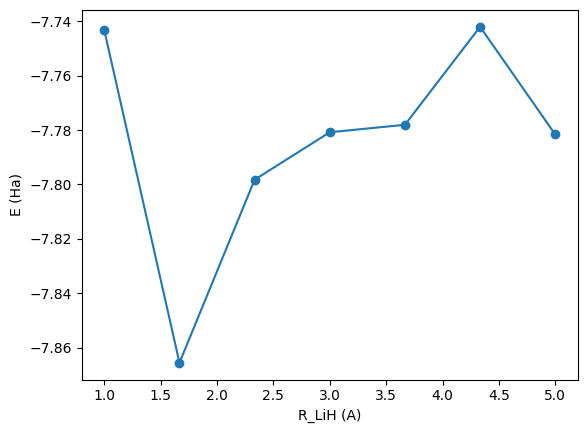

In [12]:
plt.plot(bond_length,energy_molecule, '-o')
plt.xlabel('R_LiH (A)')
plt.ylabel('E (Ha)')

In [16]:
dipole_moment =[]
for i in range(len(Elec_dipole_Moment)):
    dm = abs(sum(-comb_dipole[i]+(Elec_dipole_Moment[i]))*au2debye)
    dipole_moment.append(dm)

Text(0, 0.5, 'E (Ha)')

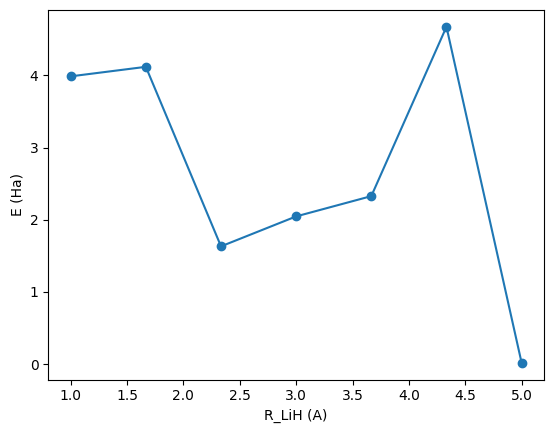

In [17]:
plt.plot(bond_length,dipole_moment, '-o')
plt.xlabel('R_LiH (A)')
plt.ylabel('E (Ha)')

Prototype programs compared to VQEClient is much more easy in terms of number of jobs that we can sent in a go. But on downside we only get electronic energy and electronic dipole moment, contribution from nucleus and core electrons needed to be calculated seperartely.